# 📊 YouTube Comment Spam Detection with Ensemble Learning
This notebook builds a spam detection model using an ensemble of Logistic Regression, Multinomial Naive Bayes, and Support Vector Machine. It includes text preprocessing, TF-IDF vectorization, and performance evaluation using a labeled CSV dataset.

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc


In [ ]:
# Load CSV data (ensure it has 'comment' and 'label' columns)
df = pd.read_csv("YoutubeCommentsDataSet.csv")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (18408, 2)


,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [ ]:
# Basic text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_comment'] = df['Comment'].astype(str).apply(clean_text)
df[['Comment', 'clean_comment']].head()


,Comment,clean_comment
0,lets not forget that apple pay in 2014 require...,lets not forget that apple pay in required a b...
1,here in nz 50 of retailers don’t even have con...,here in nz of retailers dont even have contact...
2,i will forever acknowledge this channel with t...,i will forever acknowledge this channel with t...
3,whenever i go to a place that doesn’t take app...,whenever i go to a place that doesnt take appl...
4,apple pay is so convenient secure and easy to ...,apple pay is so convenient secure and easy to ...


In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\\S+|www\\S+", '', text)
    text = re.sub(r'[^a-zA-Z\\s]', '', text)
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\goelp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Features and labels
X = df['clean_comment']
y = df['Sentiment']

# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_tfidf = vectorizer.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42, stratify=y)


In [ ]:
# Define classifiers
lr = LogisticRegression(max_iter=1000)
nb = MultinomialNB()
svm = SVC(kernel='linear', probability=True)

# Ensemble with soft voting
ensemble = VotingClassifier(estimators=[
    ('lr', lr),
    ('nb', nb),
    ('svm', svm)
], voting='soft')

# Train model
ensemble.fit(X_train, y_train)


Accuracy: 0.7291327177258736

Classification Report:
               precision    recall  f1-score   support

    negative       0.77      0.20      0.31       701
     neutral       0.67      0.46      0.54      1392
    positive       0.74      0.95      0.83      3430

    accuracy                           0.73      5523
   macro avg       0.73      0.53      0.56      5523
weighted avg       0.73      0.73      0.69      5523



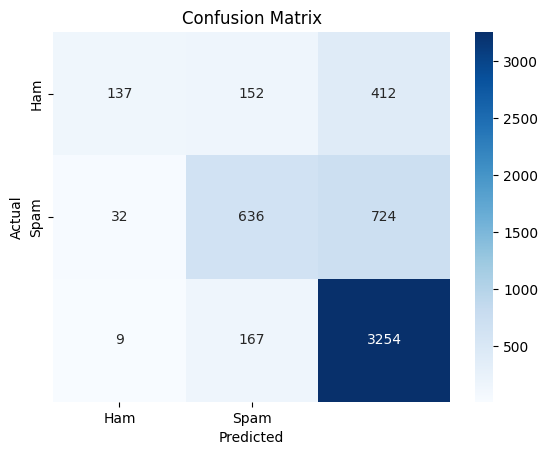

In [ ]:
# Predict and evaluate
y_pred = ensemble.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


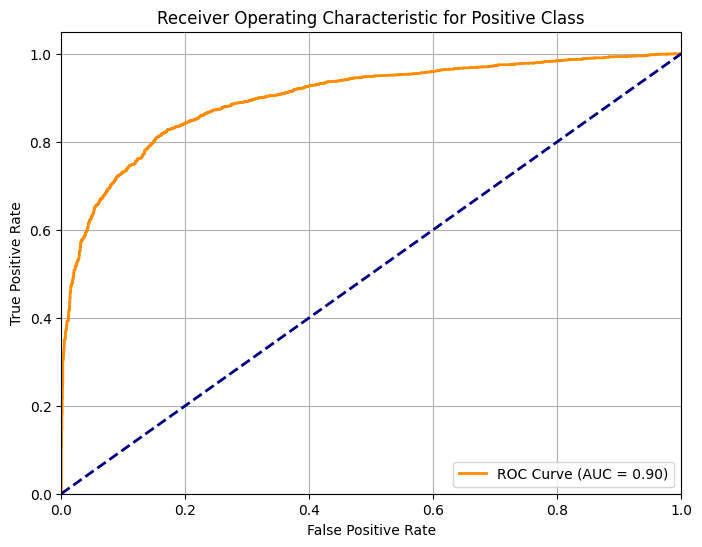

In [ ]:
# Compute ROC curve and AUC for the "positive" class
from sklearn.preprocessing import label_binarize

# Binarize y_test: 1 if 'positive', 0 otherwise
y_test_bin = label_binarize(y_test, classes=['negative', 'neutral', 'positive'])[:, 2]

# Get prediction probabilities for "positive" class
y_proba = ensemble.predict_proba(X_test)[:, 2]

fpr, tpr, thresholds = roc_curve(y_test_bin, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Positive Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
